In [5]:
import sys,os

sys.path.append('../Flooding1/') # to access prep_data, util and unet files. 
import matplotlib.pyplot as plt
import matplotlib as mlp
from sklearn.preprocessing import StandardScaler, MinMaxScaler,MaxAbsScaler, RobustScaler
from sklearn.model_selection import train_test_split
from skimage.transform import resize
import numpy as np
from prep_data import Dataset
import torch
from torch import autograd
from torch.utils.data import DataLoader
from unet import UNet
import torch.nn as  nn
import random
from scipy.ndimage.filters import gaussian_filter1d
from util import  plot_models1D, plot_history, scale_data, plot_models1D2
import time 



ModuleNotFoundError: No module named 'net'

In [2]:


def r2_score(target, prediction):
    """Calculates the r2 score of the model
    
    Args-
        target- Actual values of the target variable
        prediction- Predicted values, calculated using the model
        
    Returns- 
        r2- r-squared score of the model
    """
    r2 = 1- torch.sum((target-prediction)**2) / torch.sum((target-target.float().mean())**2)
    return r2.cpu().detach()


def run_training(model,opt,criterion,training_data,valid_data,num_epoch=100,batchsz=32):
	ntrain = training_data.x_data.shape[0]
	nvalid = valid_data.y_data.shape[0]
	train_loader= DataLoader (dataset=training_data,batch_size=batchsz,shuffle=True)
	valid_loader= DataLoader(dataset=valid_data,batch_size=batchsz,shuffle=True)

	scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt,mode='min',patience=5,threshold=1e-8,verbose=True)		
	loss_train = []
	loss_valid = []
	R2_train = []
	R2_valid = []
	t_start = time.time()
	# add_noise = GaussianNoise(0.01) # This is a noise layer, used for regularization only for training, changing the standard deviation might change the output
	for epoch in range (num_epoch):
		epoch_train_loss=0
		R2_train_running=0
		# loop over batches
		for batch,data in enumerate (train_loader,0):
			inputs,targets = data
			# inputs = inputs.view(inputs.shape[0],1,inputs.shape[1])
			targets = targets.view(targets.shape[0],1,targets.shape[1])
			# inputs = add_noise(inputs)
			pred = model(inputs)
			loss = criterion(pred,targets) 
			R2_train_running += r2_score(targets,pred)
			epoch_train_loss += loss.item()
			loss.backward()
			optimizer.step()
			optimizer.zero_grad()
		epoch_train_loss = epoch_train_loss/(ntrain/batchsz)
		R2_train_running = R2_train_running/(ntrain/batchsz) 

		with torch.no_grad():
			epoch_valid_loss=0 
			R2_valid_running=0
			for batch,data in enumerate (valid_loader,0):
				inputs,targets = data
				targets = targets.view(targets.shape[0],1,targets.shape[1])
				pred = model(inputs)
				loss = criterion(pred,targets)
				R2_valid_running += r2_score(targets,pred)
				epoch_valid_loss += loss.item()
			epoch_valid_loss = epoch_valid_loss/(nvalid/batchsz)
			R2_valid_running = R2_valid_running/(nvalid/batchsz) 

		scheduler.step(epoch_valid_loss)

		loss_train.append(epoch_train_loss)
		loss_valid.append(epoch_valid_loss)	
		R2_train.append(R2_train_running)
		R2_valid.append(R2_valid_running)
		print(f'''epoch: {epoch+1:3}/{num_epoch:3}  Training_loss: {epoch_train_loss:.5e}  Validation_loss: {epoch_valid_loss:.5e}
		 R2_Training: {R2_train_running:.5}  R2_Validation: {R2_valid_running:.5}''')
	t_end = time.time()
	print("=================================================")
	print(f"Training time is {(t_end-t_start)/60} minutes.")
	print("=================================================")

	return model,np.array(loss_train),np.array(loss_valid),np.array(R2_train),np.array(R2_valid)
	# return model,loss_train,loss_valid,R2_train,R2_valid




## For determinstic behaviour 

## For determinstic behaviour 

In [3]:
torch.backends.cudnn.deterministic = True
random.seed(1)
np.random.seed(1)
torch.manual_seed(1)
torch.cuda.manual_seed(1)



## i/o files 

In [4]:
# reading the inputs and targets
data_file = 'output_ibx_copy'
path_data = f'../gen_data/{data_file}/'
ifile = 1
endfile= 10000

# Net par
batchsz= 32
LR = 0.001
num_epoch =  50
chanl = 16
in_channels = 1 # input channel
test_ratio = 0.2 # for splitting the data 
skip = False 
netname = f'unet_flood2nd_{data_file}_lr{LR}_chanl{chanl}_batch{batchsz}_skip{int(skip)}'  # train with bp_mean
print(netname)

# Read the first file 
inp2=np.load(path_data+'inv_2nd_m'+str(ifile)+'.npy') 
true2 =np.load(path_data+'true_m'+str(ifile)+'.npy')
init2 =np.load(path_data+'pred1_m'+str(ifile)+'.npy')
oup2 =np.load(path_data+'flood_m'+str(ifile)+'.npy')
print('shape of the first reading file ',init2.shape)

# Allocate the arrays 
nm = inp2.shape[0]
nt = inp2.shape[1]
inp = np.zeros((endfile,nt))
oup = np.zeros((endfile,nt))
init = np.zeros((endfile,nt))
true = np.zeros((endfile,nt))
print('number of allocating array  for data is ',init.shape)
inp[0,:] = inp2
oup[0,:] = oup2
init[0,:] = init2
true[0,:] = true2
for k in range(ifile,endfile):
	if os.path.isfile(path_data+'flood_m'+str(k)+'.npy') and os.path.isfile(path_data+'true_m'+str(k)+'.npy') and os.path.isfile(path_data+'init_m'+str(k)+'.npy'):
		inp_tmp = np.load(path_data+'inv_2nd_m'+str(k)+'.npy')
		oup_tmp = np.load(path_data+'flood_m'+str(k)+'.npy')
		init_tmp = np.load(path_data+'pred1_m'+str(k)+'.npy')
		true_tmp = np.load(path_data+'true_m'+str(k)+'.npy')
		inp[nm,:] = inp_tmp
		oup[nm,:] = oup_tmp
		init[nm,:] = init_tmp
		true[nm,:] = true_tmp
		nm +=1
		if k%1000==0:print('number of models', nm)       
inp =  inp[~np.all(inp == 0, axis=1)]
oup =  oup[~np.all(oup == 0, axis=1)]	
init =  init[~np.all(init == 0, axis=1)]	
true =  true[~np.all(true == 0, axis=1)]	
print ('loaded shapes for input and output',inp.shape, oup.shape)	

path_output='./output'
if not os.path.exists(path_output):
    os.makedirs(path_output) 
    
path_fig = './output/figure'
if not os.path.exists(path_fig):
    os.makedirs(path_fig) 

path_net = './output/net'
if not os.path.exists(path_net):
    os.makedirs(path_net) 
    

unet_flood2nd_output_ibx_copy_lr0.001_chanl16_batch32_skip0
shape of the first reading file  (1, 200)
number of allocating array  for data is  (10000, 200)
number of models 1001
number of models 2001
number of models 3001
number of models 4001
number of models 5001
number of models 6001
number of models 7001
number of models 8001
number of models 9001
loaded shapes for input and output (10000, 200) (10000, 200)


## Plotting the loaded data 

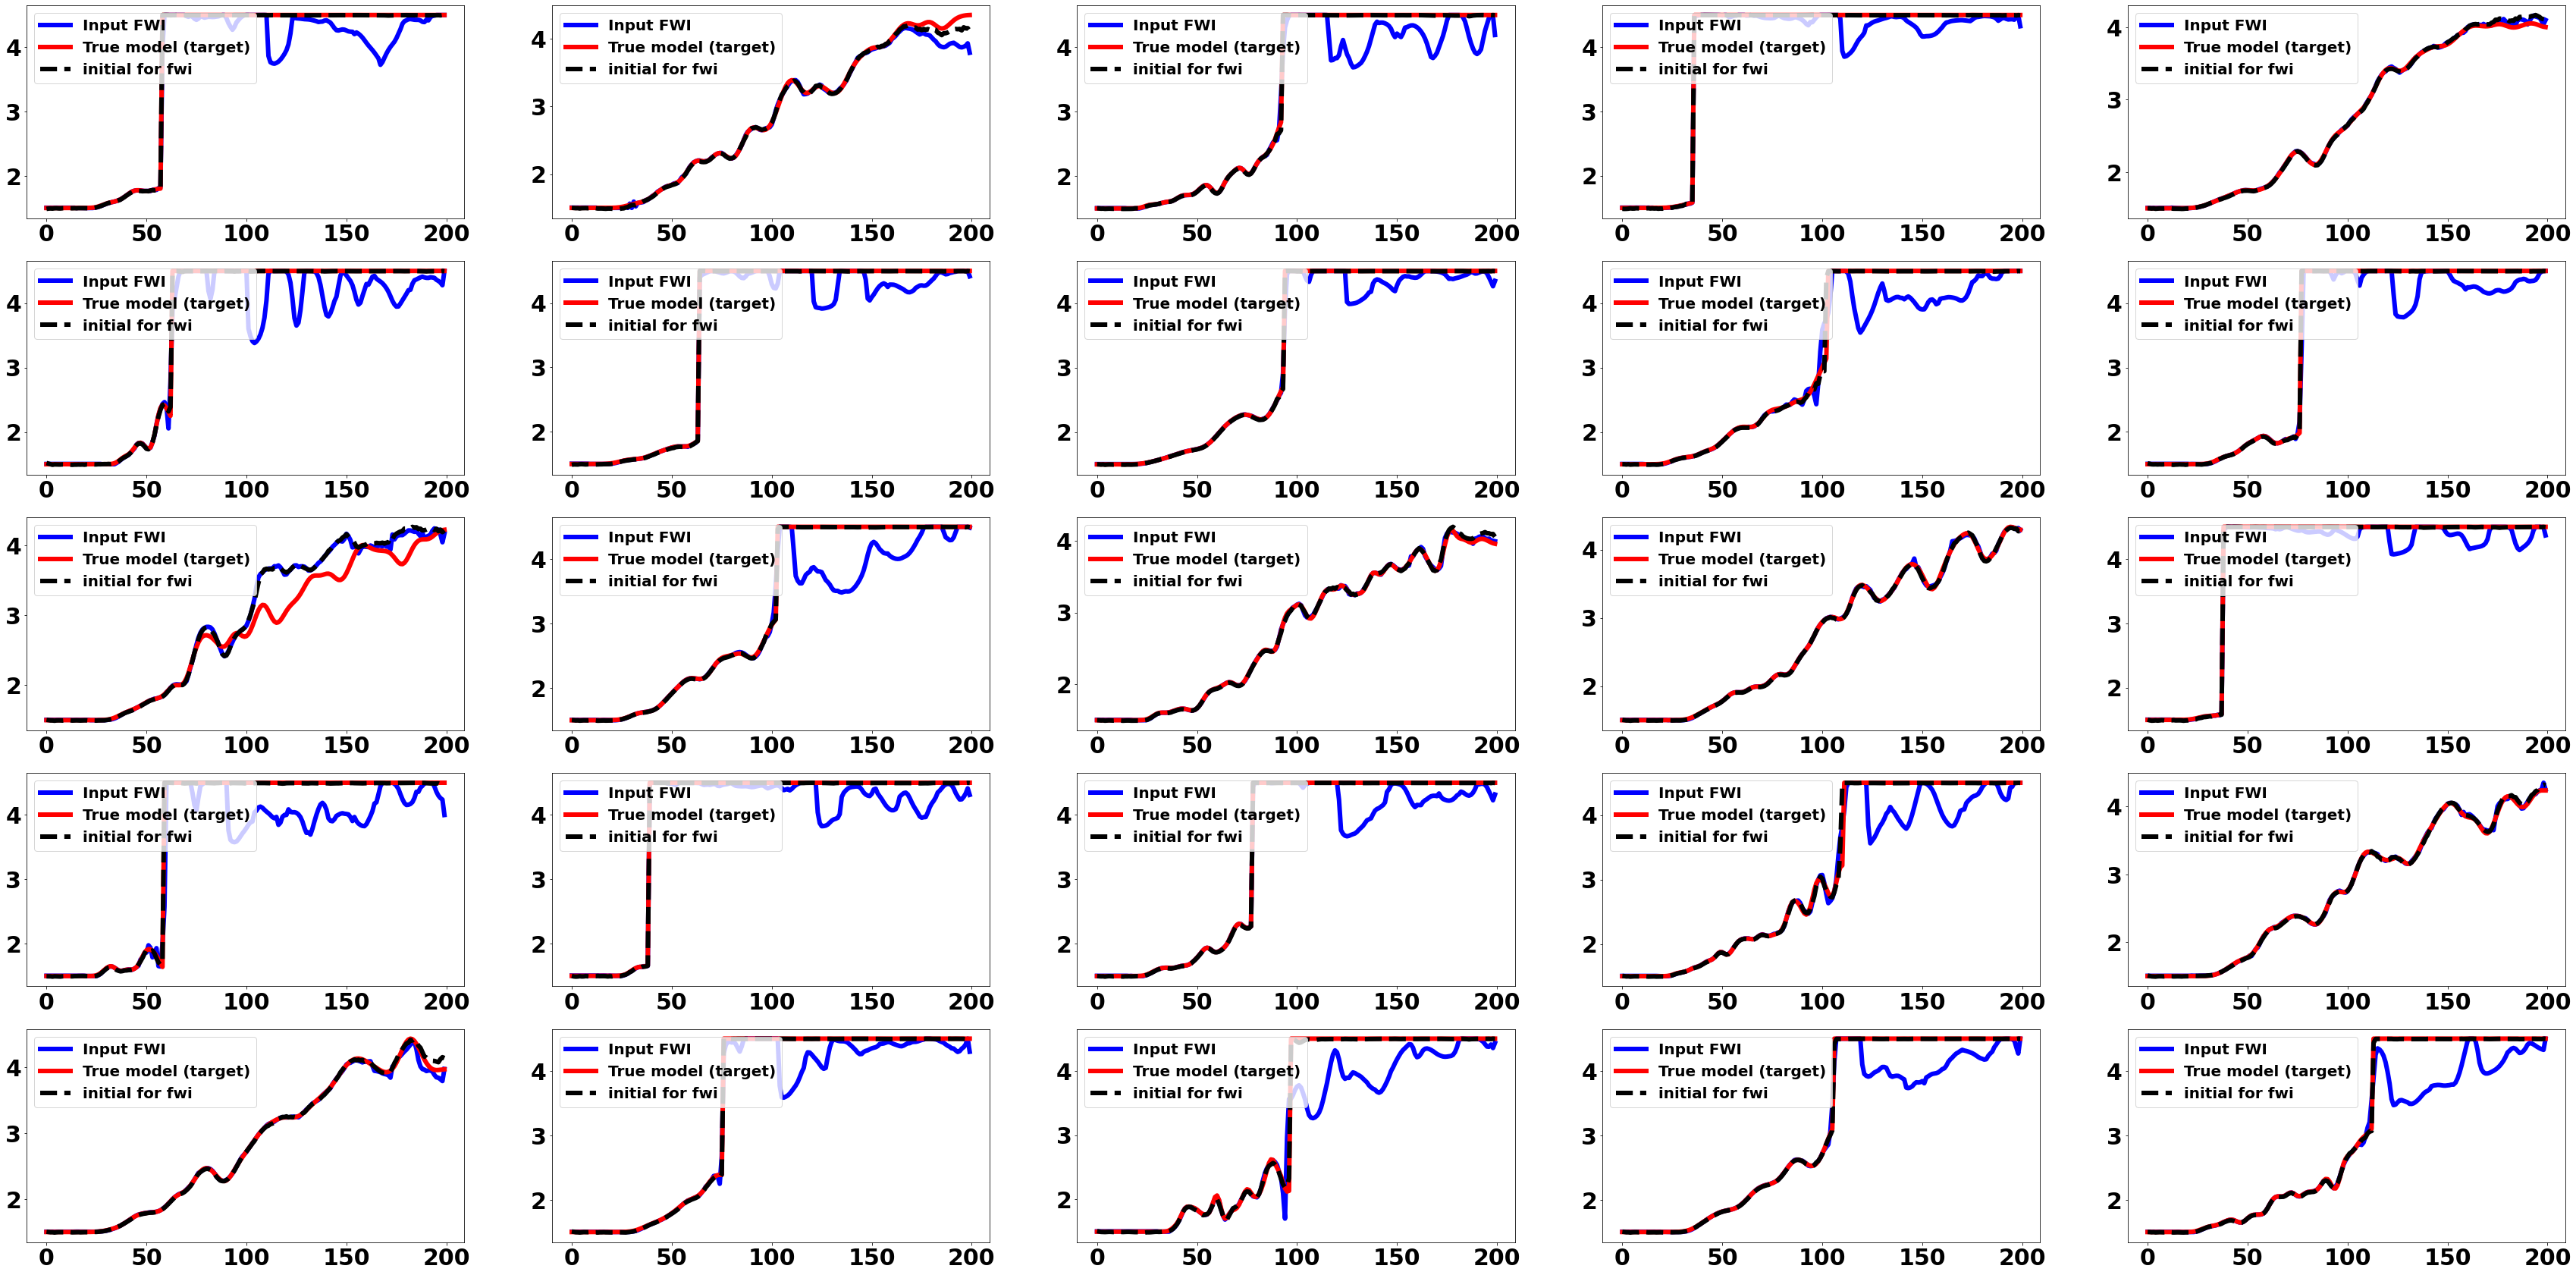

In [5]:
plot_models1D2(inp,oup,init,inp.shape[0],5,5)

In [6]:
## Defining  parameters 

## Preparing input and output

In [7]:

inp = inp.reshape((inp.shape[0],1,inp.shape[1]))
# init = init.reshape((init.shape[0],1,init.shape[1]))
# inp = np.concatenate((inp,init),axis=1)


# Normalize the data 
inp = inp/4.5
oup = oup/4.5
init = init/4.5

## Split data into training and inference 

In [8]:

# split training and validation
x_train,x_valid, y_train, y_valid,init_train, init_valid, true_train, true_valid = train_test_split(inp,oup,init,true, test_size=test_ratio)
ntrain = x_train.shape[0]
nvalid = x_valid.shape[0]

np.save(f'{path_output}/xtrain_{netname}',x_train)
np.save(f'{path_output}/ytrain_{netname}',y_train)
np.save(f'{path_output}/init_train_{netname}',init_train)
np.save(f'{path_output}/true_train_{netname}',true_train)

np.save(f'{path_output}/xvalid_{netname}',x_valid)
np.save(f'{path_output}/yvalid_{netname}',y_valid)
np.save(f'{path_output}/init_valid_{netname}',init_valid)
np.save(f'{path_output}/true_valid_{netname}',true_valid)




In [9]:
print('shape of the training data is ', x_train.shape)
print('number of training: ',ntrain )
print('number of validation: ',nvalid )
print('Batch: ',batchsz )

shape of the training data is  (8000, 1, 200)
number of training:  8000
number of validation:  2000
Batch:  32


## Prepare data for pytorch 

In [10]:

training_data=Dataset(x_train,y_train)
valid_data =Dataset(x_valid,y_valid)


## Defining the model 

In [11]:

# define NN model
model = UNet(in_channels=in_channels,out_channels=1,init_features=chanl)
# model = UNet(in_channels=10,out_channels=1,init_features=chanl) # For this use unference 2
model.cuda()
# this should be outer loop
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
criterion = nn.MSELoss() 





## Run training 

In [12]:
# Run trainnig 
model, loss_train, loss_valid, r2_train,r2_valid = run_training(model,optimizer,criterion,training_data,valid_data,num_epoch)




epoch:   1/ 50  Training_loss: 5.45547e-03  Validation_loss: 1.37161e-03
		 R2_Training: 0.9337  R2_Validation: 0.99139
epoch:   2/ 50  Training_loss: 6.05853e-04  Validation_loss: 9.16994e-04
		 R2_Training: 0.99262  R2_Validation: 0.99685
epoch:   3/ 50  Training_loss: 3.72808e-04  Validation_loss: 8.32760e-04
		 R2_Training: 0.99546  R2_Validation: 0.99789
epoch:   4/ 50  Training_loss: 2.75329e-04  Validation_loss: 7.67480e-04
		 R2_Training: 0.99664  R2_Validation: 0.99866
epoch:   5/ 50  Training_loss: 2.09557e-04  Validation_loss: 6.78431e-04
		 R2_Training: 0.99744  R2_Validation: 0.99976
epoch:   6/ 50  Training_loss: 2.12779e-04  Validation_loss: 7.03004e-04
		 R2_Training: 0.9974  R2_Validation: 0.99944
epoch:   7/ 50  Training_loss: 1.92161e-04  Validation_loss: 6.71559e-04
		 R2_Training: 0.99765  R2_Validation: 0.99982
epoch:   8/ 50  Training_loss: 1.75138e-04  Validation_loss: 8.16887e-04
		 R2_Training: 0.99785  R2_Validation: 0.99803
epoch:   9/ 50  Training_loss: 1.7

Done training yaaaaaay --------


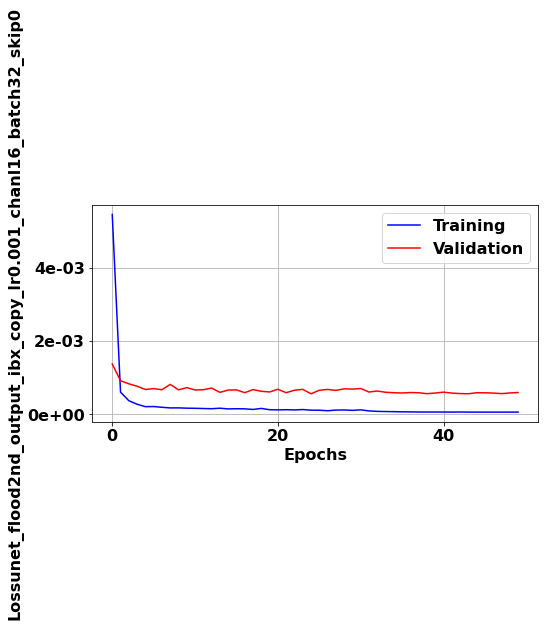

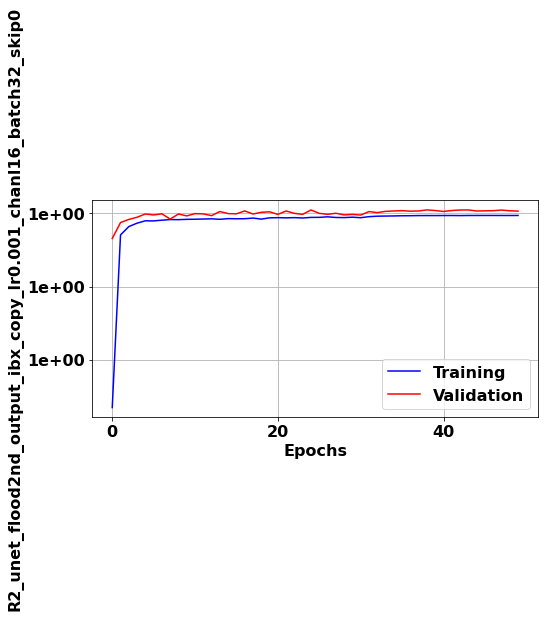

In [13]:
torch.save(model.state_dict(),f'{path_net}/{netname}.pt')
np.save(path_output+'/Training_loss_'+netname,np.array(loss_train))     
np.save(path_output+'/Validation_loss_'+netname,np.array(loss_valid))
np.save(path_output+'/Training_R2_'+netname,np.array(r2_train))
np.save(path_output+'/Validation_R2_'+netname,np.array(r2_valid))

plot_history(loss_train,loss_valid,name='Loss'+netname) 
plot_history(r2_train,r2_valid,name='R2_'+netname)  
print('Done training yaaaaaay --------')

